# Sentence-BERT data augmentation

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

data_dir = Path("stsbenchmark")
assert data_dir.exists()

In [2]:
import pandas as pd

# Load df dataset
df_train = pd.read_feather(data_dir / "sts-train.feather")
df_dev = pd.read_feather(data_dir / "sts-dev.feather")
df_test = pd.read_feather(data_dir / "sts-test.feather")

## Compute Embeddings
Use Sentence-BERT to compute sentence embeddings

In [3]:
import torch
from sentence_transformers import SentenceTransformer

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"using device: {device}")

# load sbert model
model = SentenceTransformer("stsb-mpnet-base-v2")

using device: cuda:0


In [4]:
# compute sentence embeddings with sbert
emb_train_1 = model.encode(df_train.s1, convert_to_tensor=True, device=device)
emb_train_2 = model.encode(df_train.s2, convert_to_tensor=True, device=device)

In [5]:
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# compute similarity scores via cosine similarity
emb_train_1 = F.normalize(emb_train_1)
emb_train_2 = F.normalize(emb_train_2)
y_pred_train = (emb_train_1.unsqueeze(1) @ emb_train_2.unsqueeze(2)).squeeze(1).cpu().numpy()
# scale scores to [0, 1]
y_pred_train = MinMaxScaler().fit_transform(y_pred_train).squeeze()

SpearmanRank: 0.9651


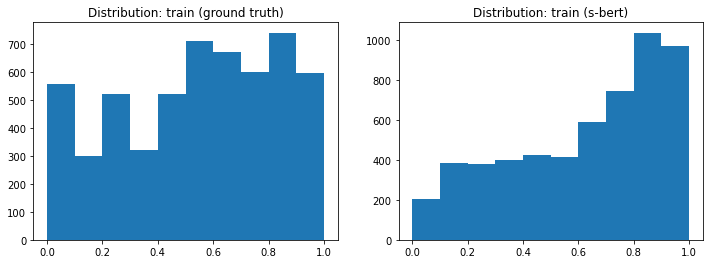

In [6]:
from scipy.stats import spearmanr

spearman = spearmanr(y_pred_train, df_train.score)[0]
print(f"SpearmanRank: {spearman:.4f}")

# plot distributions
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(df_train.score, bins=10)
ax[0].set_title("Distribution: train (ground truth)")
ax[1].hist(y_pred_train, bins=10)
ax[1].set_title("Distribution: train (s-bert)")
plt.show()

In [7]:
# save benchmark dataset with sbert scores
df_train_sbert = df_train.copy()
df_train_sbert.score = y_pred_train
df_train_sbert.to_feather(data_dir / "sts-train-sbert.feather")

In [8]:
# compute sentence embeddings with sbert
emb_dev_1 = model.encode(df_dev.s1, convert_to_tensor=True, device=device)
emb_dev_2 = model.encode(df_dev.s2, convert_to_tensor=True, device=device)

# compute similarity scores via cosine similarity
emb_dev_1 = F.normalize(emb_dev_1)
emb_dev_2 = F.normalize(emb_dev_2)
y_pred_dev = (emb_dev_1.unsqueeze(1) @ emb_dev_2.unsqueeze(2)).squeeze(1).cpu().numpy()
# scale scores to [0, 1]
y_pred_dev = MinMaxScaler().fit_transform(y_pred_dev).squeeze()

# save benchmark dataset with sbert scores
df_dev_sbert = df_dev.copy()
df_dev_sbert.score = y_pred_dev
df_dev_sbert.to_feather(data_dir / "sts-dev-sbert.feather")

In [9]:
# compute sentence embeddings with sbert
emb_test_1 = model.encode(df_test.s1, convert_to_tensor=True, device=device)
emb_test_2 = model.encode(df_test.s2, convert_to_tensor=True, device=device)

# compute similarity scores via cosine similarity
emb_test_1 = F.normalize(emb_test_1)
emb_test_2 = F.normalize(emb_test_2)
y_test_dev = (emb_test_1.unsqueeze(1) @ emb_test_2.unsqueeze(2)).squeeze(1).cpu().numpy()
# scale scores to [0, 1]
y_test_dev = MinMaxScaler().fit_transform(y_test_dev).squeeze()

# save benchmark dataset with sbert scores
df_test_sbert = df_test.copy()
df_test_sbert.score = y_test_dev
df_test_sbert.to_feather(data_dir / "sts-test-sbert.feather")

## Create augmentation data
Create new sentence pairs and score them via cosine similarity

In [10]:
emb_1 = torch.cat([emb_train_1, emb_dev_1])
emb_2 = torch.cat([emb_train_2, emb_dev_2])
y_true = pd.concat([df_train.score, df_dev.score])

In [11]:
# create array that holds all possible index pair combinations
indices = np.arange(emb_1.shape[0])
index_pairs = np.stack(np.meshgrid(indices, indices), axis=-1).reshape(-1, 2)
print(f"#sentence-pairs: {index_pairs.shape[0]}")

#sentence-pairs: 49420900


In [12]:
from tqdm.notebook import tqdm

# compute scores via cosine similarity
# batching needed due to the insane number of sentence pairs
dataloader = torch.utils.data.DataLoader(index_pairs, batch_size=8192)
y_pred_augment = torch.cat([
    emb_1[idxs[:, 0]].unsqueeze(1) @ emb_2[idxs[:, 1]].unsqueeze(2)
    for idxs in tqdm(dataloader)
]).squeeze(1).cpu().numpy()
# scale scores to [0, 1]
y_pred_augment = MinMaxScaler().fit_transform(y_pred_augment).squeeze()

  0%|          | 0/6033 [00:00<?, ?it/s]

In [13]:
df_augment = pd.DataFrame({
    "idx1": index_pairs[..., 0],
    "idx2": index_pairs[..., 1],
    "score": y_pred_augment
})

In [35]:
N_BINS = 100
SEED = 1337
np.random.seed(1337)
mu = 1
sig = 0.4
f = lambda x: 1 / (2*np.pi*sig**2) * np.exp(-(x - mu)**2 / (2*sig**2)) * 10  # normal distribution
X = np.linspace(0, 1, N_BINS)

In [15]:
# create bins
bins = np.histogram_bin_edges(df_augment.score, bins=N_BINS)
indices = np.digitize(df_augment.score, bins)

In [16]:
# sampling from bins
sample_idxs = []
for i, x in enumerate(tqdm(X)):
    bin_indices = np.where(indices == i)[0]
    if len(bin_indices) > 1:
        n = int(f(x))
        if len(bin_indices) < n:
            sample_idxs.append(bin_indices)
        else:
            sample_idxs.append(np.random.choice(bin_indices, size=n, replace=False))
# concatenate sampled bins together
sample_idxs = np.concatenate(sample_idxs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
# create dataframe of sampled examples and save it to disk
df_augment_sampled = df_augment.iloc[sample_idxs].reset_index()
df_augment_sampled.to_feather(data_dir / "df_augment.feather")
print(f"{len(df_augment_sampled)} examples sampled")

438 examples sampled


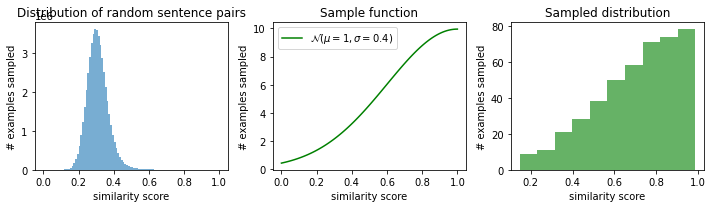

In [57]:
_, ax = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
ax[0].hist(df_augment.score, bins=100, alpha=0.6)
ax[0].set_title("Distribution of random sentence pairs")
ax[0].set_xlabel("similarity score")
ax[0].set_ylabel("# examples sampled")

ax[1].plot(X, f(X), label=r"$\mathcal{N}(\mu=1, \sigma=0.4)$", color="green", alpha=1.0)
ax[1].set_title("Sample function")
ax[1].set_ylabel("# examples sampled")
ax[1].set_xlabel("similarity score")
ax[1].legend()

ax[2].hist(df_augment_sampled.score, bins=10, color="green", alpha=0.6)
ax[2].set_title("Sampled distribution")
ax[2].set_ylabel("# examples sampled")
ax[2].set_xlabel("similarity score")
plt.savefig("sample_distribution.pdf")
plt.show()

In [37]:
# # plot distributions
# _, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].hist(df_augment_sampled.score, bins=10)
# ax[0].set_title("Distribution: augmentation")
# ax[1].hist(np.concatenate([df_augment_sampled.score, y_true]), bins=10)
# ax[1].set_title("Distribution: train + augmented")
# plt.show()